# Analyse consecutive conflicts between the same flights #

In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors
from mpl_toolkits.basemap import Basemap
import conflict
import analysis
import os
import networkx as nx
import tools
import matplotlib.backends.backend_pdf
import matplotlib.backends.backend_pgf

In [2]:
# read in all data
inputFile = '../data/TrajDataV2_20120729.txt'
trajectories = pd.read_csv('%s.csv' % inputFile, index_col='flightIndex')

mindistance = 30.0
mintime = 21
delayPerConflict = 0
dthreshold = 3
maxDepartDelay = 18

name = "mindist%05.1f_mintime%03i" % (mindistance, mintime)
rawPointConflictFile = '%s.%s.rawPointConflicts.csv' % (inputFile, name)
pointConflictFile = '%s.%s.pointConflicts.csv' % (inputFile, name)       
parallelConflictFile = '%s.%s.parallelConflicts.csv' % (inputFile, name)
flights2ConflictsFile = "%s.%s.flights2Conflicts_delay%03i_thres%03i_depart%03i.h5" % (inputFile, name, delayPerConflict, dthreshold, maxDepartDelay)
reducedPointConflictFile = "%s.%s.reducedPointConflicts_delay%03i_thres%03i_depart%03i.csv" % (inputFile, name, delayPerConflict, dthreshold, maxDepartDelay)
reducedParallelConflictFile = "%s.%s.reducedParallelConflicts_delay%03i_thres%03i_depart%03i.csv" % (inputFile, name, delayPerConflict, dthreshold, maxDepartDelay)

rawPointConflicts = pd.read_csv(rawPointConflictFile, index_col='conflictIndex')
pointConflicts = pd.read_csv(pointConflictFile, index_col='conflictIndex')
parallelConflicts = pd.read_csv(parallelConflictFile, index_col='parallelConflict')
flights2Conflicts = pd.read_hdf(flights2ConflictsFile, 'flights2Conflicts')
reducedPointConflicts = pd.read_csv(reducedPointConflictFile, index_col='conflictIndex')
reducedParallelConflicts= pd.read_csv(reducedParallelConflictFile, index_col='parallelConflict')        

For each pair of flights
  * Check if there are more than one conflicts
  * If yes, calculate the difference in the maximum and minimum time difference

In [3]:
# calculate time diff
c = pointConflicts
c['minTimeDiff'] = c.time1 - c.time2
c['maxTimeDiff'] = c.time1 - c.time2
# drop unwanted columns
c = c[['flight1', 'flight2', 'minTimeDiff', 'maxTimeDiff']]
NPointConflicts = c.shape[0]

In [4]:
# calculate time diff
pc = parallelConflicts
pc['timeDiff'] = pc.time1 - pc.time2
# conflict index as column
pc = pc.reset_index()
# group by conflict index
grouped = pc.groupby('parallelConflict')
# calculate minimum and maximum time difference while keeping flight numbers
pc = grouped.agg({'flight1': 'mean', 'flight2': 'mean', 'timeDiff': [min, max]})
# set right columns
pc.columns = ['flight1', 'minTimeDiff', 'maxTimeDiff', 'flight2']
# shift index 
pc.index = pc.index + NPointConflicts

In [5]:
# concatenate point and parallel conflicts
conflicts = pd.concat([c, pc])
conflicts.index.name = 'conflictIndex'
conflicts = conflicts.reset_index()

In [6]:
%matplotlib inline

## Number of conflicts per pair of flights ##

In [7]:
# group by pair of flights
grouped = conflicts.groupby(['flight1', 'flight2'])
numberOfConflictsPerFlightPair = grouped.agg({'conflictIndex': lambda x: len(set(list(x)))})

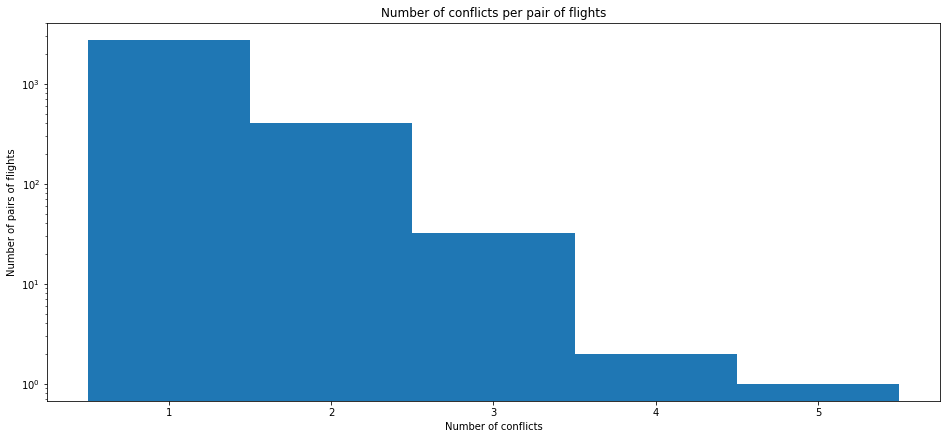

In [8]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(2, 1, 1)
numberOfConflictsPerFlightPair.hist(bins=[0.5 + i for i in range(int(numberOfConflictsPerFlightPair.max()) + 1)], ax=ax);
ax.set_yscale('log')
ax.set_title('Number of conflicts per pair of flights')
ax.set_xlabel('Number of conflicts')
ax.set_ylabel('Number of pairs of flights');
ax.grid('off')

## Are there pairs of flights with non-consecutive conflict intervals? ##

In [9]:
def intervalsAreConsecutive(df):
    df = df.sort_values(by=['minTimeDiff', 'maxTimeDiff'])
    u = df.maxTimeDiff.values
    l = df.minTimeDiff.values
    N = len(u)
    for i in range(1, N):
        if max(u[:i]) < l[i] - 1:
            return False
    return True
def maximumGapBetweenIntervals(df):
    df = df.sort_values(by=['minTimeDiff', 'maxTimeDiff'])
    u = df.maxTimeDiff.values
    l = df.minTimeDiff.values
    N = len(u)
    maxGap = np.nan
    for i in range(1, N):
        gap = l[i] - max(u[:i])
        if gap > 0 and (np.isnan(maxGap) or gap > maxGap):
            maxGap = gap
    return maxGap

In [10]:
consecutiveIntervals = conflicts.groupby(['flight1', 'flight2']).apply(intervalsAreConsecutive)

In [11]:
nConflictInfo = pd.concat([numberOfConflictsPerFlightPair, consecutiveIntervals], axis=1)
nConflictInfo.columns = ['numberOfConflictsPerFlightPair', 'intervalsAreConsectutive']
nConflictInfo.head()

numberOfConflictsPerFlightPair intervalsAreConsectutive
flight1 flight2                                                         
0       8                                     1                     True
        13                                    2                     True
1       3                                     2                     True
        5                                     2                     True
        6                                     2                     True

In [12]:
nNonConsecutiveIntervals = len(nConflictInfo[(nConflictInfo.numberOfConflictsPerFlightPair > 1) & (nConflictInfo.intervalsAreConsectutive == False)])
nMoreThanOneConflict = len(nConflictInfo[nConflictInfo.numberOfConflictsPerFlightPair > 1])

In [13]:
print "There are", nMoreThanOneConflict, "of", len(nConflictInfo), "pairs of flights with more than one conflict"
print nNonConsecutiveIntervals, "of these", nMoreThanOneConflict, "pairs of flights have non-consecutive time intervals"

There are 441 of 3183 pairs of flights with more than one conflict
45 of these 441 pairs of flights have non-consecutive time intervals


## How big are the gaps in the non-consecutive intervals ? ##

In [14]:
gaps = conflicts.groupby(['flight1', 'flight2']).apply(maximumGapBetweenIntervals)

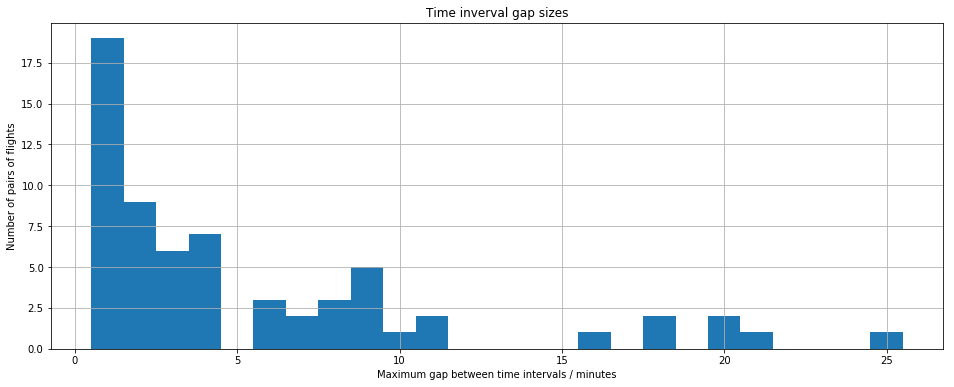

In [15]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 1, 1)
N = int(gaps.dropna().max())
gaps.dropna().sort_values().hist(ax=ax, bins=[0.5 + i for i in range(0, N + 1)])
ax.set_xlabel('Maximum gap between time intervals / minutes')
ax.set_ylabel('Number of pairs of flights')
ax.set_title('Time inverval gap sizes');
ax.grid('on')

pdf = matplotlib.backends.backend_pdf.PdfPages('potential_conflicts_non_overlapping_time_intervals_gap_sizes.pdf');
pdf.savefig(figure=fig);
pdf.close();

## How many conflicts are involved in the case of non-overlapping intervals? ##

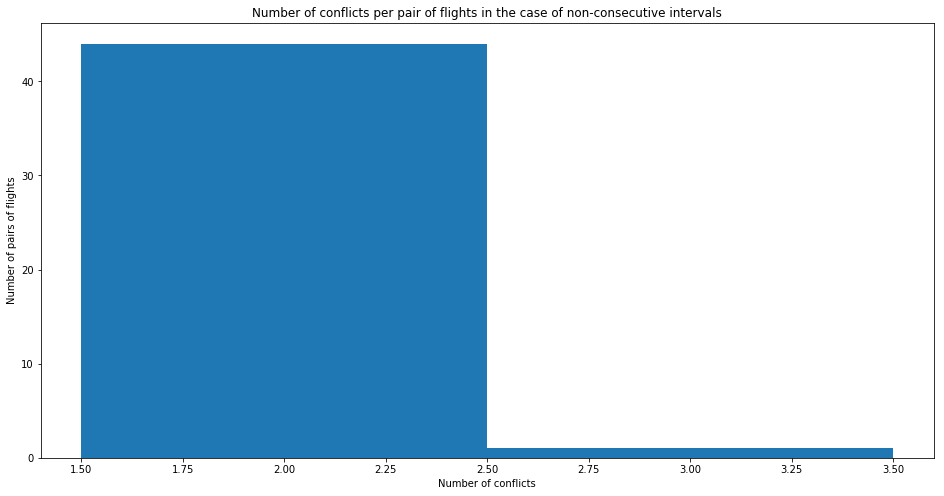

In [16]:
nConflictsNonConsecutive = nConflictInfo[nConflictInfo.intervalsAreConsectutive == False]['numberOfConflictsPerFlightPair']
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)
nConflictsNonConsecutive.hist(bins=[0.5 + i for i in range(1, int(nConflictsNonConsecutive.max()) + 1)], ax=ax);
#ax.set_yscale('log')
ax.set_title('Number of conflicts per pair of flights in the case of non-consecutive intervals')
ax.set_xlabel('Number of conflicts')
ax.set_ylabel('Number of pairs of flights');
ax.grid('off')

## Examples of pairs of flights with more than one conflict ##

In [17]:
# Filter flight pairs with 5 conflicts
nConflictsFive = nConflictInfo[nConflictInfo.numberOfConflictsPerFlightPair == 5]
nConflictsFive

,,numberOfConflictsPerFlightPair,intervalsAreConsectutive
flight1,flight2,,
28,37,5,True


In [18]:
# get example flight pair and show conflicts
f1, f2 = nConflictsFive.iloc[0].name
conflicts[(conflicts.flight1 == f1) & (conflicts.flight2 == f2)]

,conflictIndex,flight1,flight2,maxTimeDiff,minTimeDiff
1,1,28,37,-20.0,-20.0
2,2,28,37,-20.0,-20.0
3,3,28,37,-20.0,-20.0
212,212,28,37,-20.0,-20.0
213,213,28,37,-20.0,-20.0


In [19]:
# Filter flight pairs with 2 conflicts with non-consecutive intervals
nConflictsNonCons = nConflictInfo[nConflictInfo.intervalsAreConsectutive == False]
nConflictsNonCons.head()

,,numberOfConflictsPerFlightPair,intervalsAreConsectutive
flight1,flight2,,
10,12,2,False
19,28,2,False
297,316,2,False
307,314,3,False
310,314,2,False


In [20]:
# get example flight pair and show conflicts
f1, f2 = nConflictsNonCons.iloc[0].name
conflicts[(conflicts.flight1 == f1) & (conflicts.flight2 == f2)]

,conflictIndex,flight1,flight2,maxTimeDiff,minTimeDiff
69,69,10,12,-1.0,-8.0
70,70,10,12,7.0,1.0


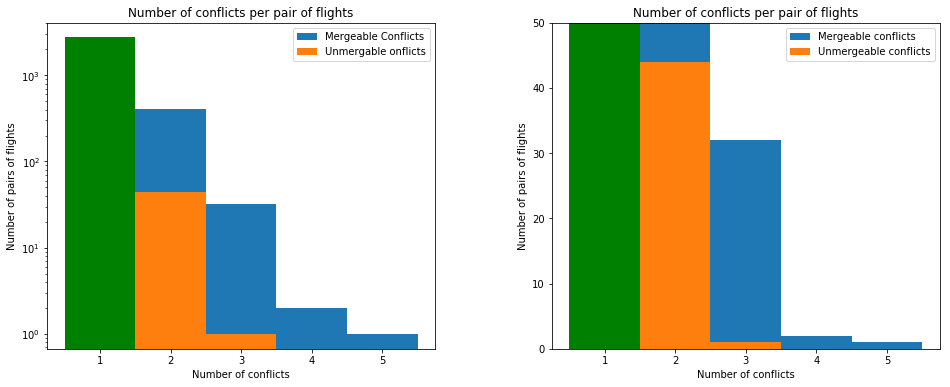

In [21]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 2, 1)
numberOfConflictsPerFlightPair.hist(bins=[0.5 + i for i in range(int(numberOfConflictsPerFlightPair.max()) + 1)], ax=ax, label='Mergeable Conflicts');
nConflictsNonConsecutive.hist(bins=[0.5 + i for i in range(1, int(nConflictsNonConsecutive.max()) + 1)], ax=ax, label='Unmergable onflicts');
numberOfConflictsPerFlightPair[numberOfConflictsPerFlightPair == 1].hist(bins=[0.5 + i for i in range(int(numberOfConflictsPerFlightPair.max()) + 1)], ax=ax, color='g');

ax.set_yscale('log')
ax.legend()
ax.set_title('Number of conflicts per pair of flights')
ax.set_xlabel('Number of conflicts')
ax.set_ylabel('Number of pairs of flights');
ax.grid('off')
ax = fig.add_subplot(1, 2, 2)

numberOfConflictsPerFlightPair.hist(bins=[0.5 + i for i in range(int(numberOfConflictsPerFlightPair.max()) + 1)], ax=ax, label='Mergeable conflicts');
nConflictsNonConsecutive.hist(bins=[0.5 + i for i in range(1, int(nConflictsNonConsecutive.max()) + 1)], ax=ax, label='Unmergeable conflicts');
numberOfConflictsPerFlightPair[numberOfConflictsPerFlightPair == 1].hist(bins=[0.5 + i for i in range(int(numberOfConflictsPerFlightPair.max()) + 1)], ax=ax, color='g');

ax.legend()
ax.set_ylim(0,50)
ax.set_title('Number of conflicts per pair of flights')
ax.set_xlabel('Number of conflicts')
ax.set_ylabel('Number of pairs of flights');
ax.grid('off')

pdf = matplotlib.backends.backend_pdf.PdfPages('potential_conflicts_non_overlapping_time_intervals_statistics.pdf');
pdf.savefig(figure=fig);
pdf.close();